<a href="https://colab.research.google.com/github/marco-hening-tallarico/Notebooks/blob/main/Copy_of_hot_rod_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 12.1 MB/s eta 0:00:00


In [3]:
# --- Imports and Connecting Backends ---
import os
os.environ["DDE_BACKEND"] = "tensorflow"  # Set to TF2 backend

import deepxde as dde
print("Backend:", dde.backend.__name__)  # Should now say: deepxde.backend.tensorflow

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Is eager execution enabled?", tf.executing_eagerly())

import deepxde as dde
print("DeepXDE version:", dde.__version__)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



Backend: deepxde.backend
TensorFlow version: 2.18.0
Is eager execution enabled? True
DeepXDE version: 1.14.0


In [4]:
# --- Setting Seeds ---
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)

# Only set torch seeds if torch is available (e.g., if not using TF backend exclusively)
# This part is optional if you are sure you'll only use TF, but good for portability
try:
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
except NameError:
    # torch is not imported or available
    pass

/tmp/ipython-input-5-1679416198.py:82: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_display_data = display_df.applymap(lambda x: f"{x:.4f}" if isinstance(x, (float, np.float64)) else x)


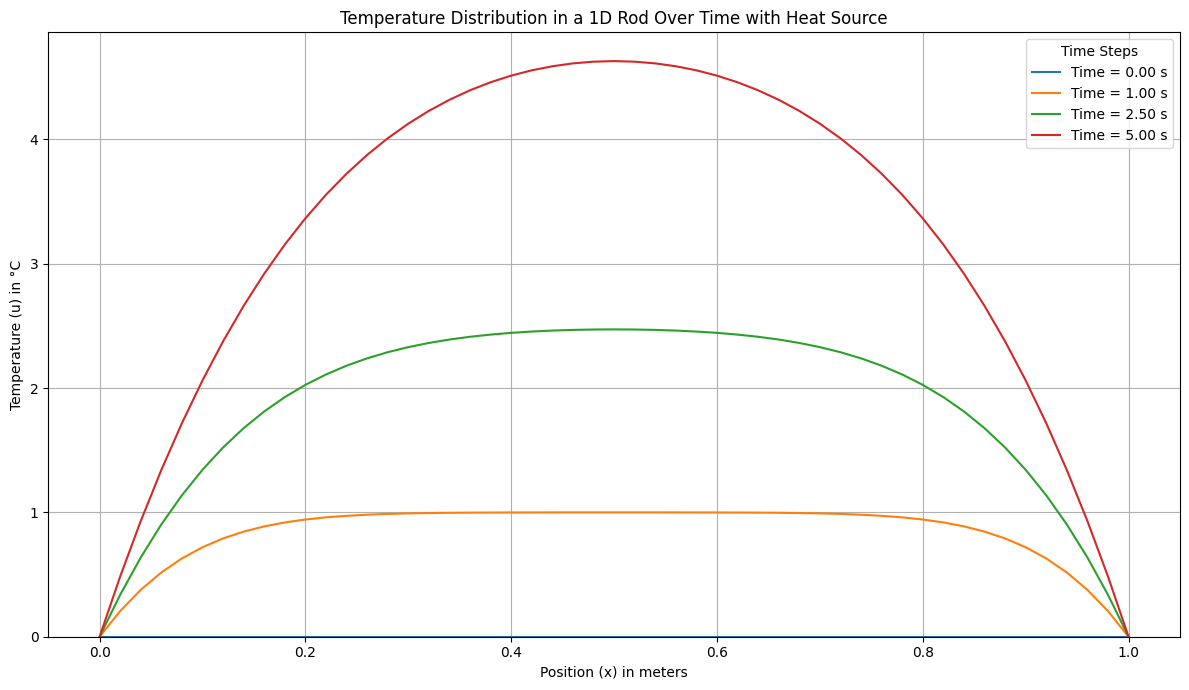

In [5]:
#--- Generating Data ---

L = 1.0  # Rod Length (m)
Nx = 51  # Number of spatial points
dx = L / (Nx - 1)  # Spatial step
T_total = 5.0  # Total time (s)
Nt = 5000  # Number of time steps
dt = T_total / Nt  # Time step
kappa = 0.01  # Thermal diffusivity (m^2/s) - This is 'k'
q = 1.0  # Constant heat source term (C/s)

u = np.zeros(Nx)
x_coords = np.linspace(0, L, Nx)
temperature_data_raw = []
header = ["Time (s)"] + [f"x={x:.2f}m" for x in x_coords]
temperature_data_raw.append(header)
temperature_data_raw.append([0.0] + u.tolist())

for n in range(1, Nt + 1):
    u_new = np.copy(u)
    for i in range(1, Nx - 1):
        u_new[i] = u[i] + dt * (kappa * (u[i+1] - 2*u[i] + u[i-1]) / (dx**2) + q)
    u_new[0] = 0.0
    u_new[Nx-1] = 0.0
    u = u_new
    if n % 50 == 0 or n == Nt: # Store initial, final and every 50th step
        temperature_data_raw.append([n * dt] + u.tolist())

# Convert the raw data to a list of lists of floats (excluding header string)
# and then to a DataFrame
data_rows = []
for row in temperature_data_raw[1:]: # Skip the header row for conversion to float
    data_rows.append([float(item) for item in row])

df = pd.DataFrame(data_rows, columns=temperature_data_raw[0])

# Select a few representative time steps to plot
# Convert column names to float for x-axis plotting, excluding the 'Time (s)' column
x_cols = [col for col in df.columns if col.startswith('x=')]
x_values = np.array([float(col.split('=')[1][:-1]) for col in x_cols])

# Select specific time indices for plotting (e.g., initial, middle, and final times)
# Ensure selected times are present or find the closest ones
selected_times = [0.0, 1.0, 2.5, 5.0] # Adjust based on data available
times_to_plot_df = df[df['Time (s)'].isin(selected_times)]

# If some selected times are not exactly in the dataframe, pick closest
if times_to_plot_df.empty:
    print("None of the exact selected times are in the DataFrame. Selecting based on closest available.")
    # Fallback: select by index if exact times are not available
    indices_to_plot = np.linspace(0, len(df) - 1, min(4, len(df))).astype(int)
    times_to_plot_df = df.iloc[indices_to_plot]

plt.figure(figsize=(12, 7))

for index, row in times_to_plot_df.iterrows():
    time_val = row['Time (s)']
    # Extract temperature values for the current time step, excluding the time column
    temp_values = row[x_cols].values.astype(float)
    plt.plot(x_values, temp_values, label=f'Time = {time_val:.2f} s')

plt.title('Temperature Distribution in a 1D Rod Over Time with Heat Source')
plt.xlabel('Position (x) in meters')
plt.ylabel('Temperature (u) in °C')
plt.grid(True)
plt.legend(title='Time Steps')
plt.ylim(bottom=0) # Ensure y-axis starts from 0 or slightly below min temp
plt.tight_layout()
plt.savefig('temperature_distribution_with_source.png')

# Display some of the data to the user in a readable format
# Select a few time steps and print their data
display_times = [0.0, 1.0, 2.5, 5.0]
display_df = df[df['Time (s)'].isin(display_times)]

# If display_df is empty because selected times aren't exact, fall back to indices
if display_df.empty:
    display_indices = np.linspace(0, len(df) - 1, min(4, len(df))).astype(int)
    display_df = df.iloc[display_indices]

# Format for printing
formatted_display_data = display_df.applymap(lambda x: f"{x:.4f}" if isinstance(x, (float, np.float64)) else x)


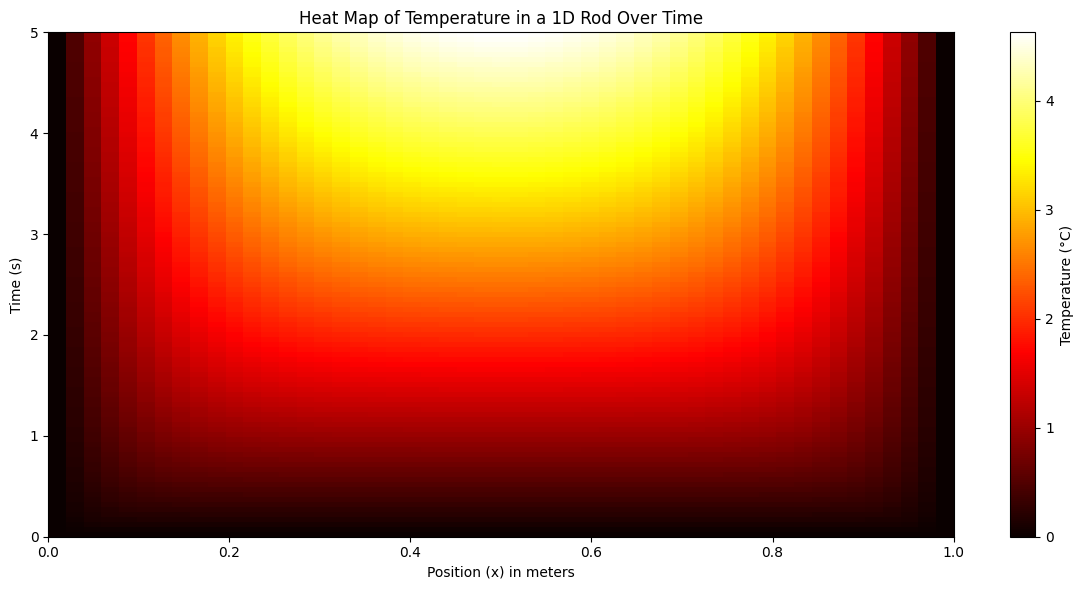

In [6]:
# --- HEAT MAP: Temperature vs. Position and Time ---

# Convert DataFrame to 2D array: rows = time steps, columns = positions
heatmap_data = df[x_cols].to_numpy()  # Shape: (time steps, spatial points)
time_vals = df['Time (s)'].to_numpy()  # Time axis for Y
x_vals = x_values  # Position axis for X

plt.figure(figsize=(12, 6))
plt.imshow(
    heatmap_data,
    aspect='auto',
    origin='lower',
    extent=[x_vals.min(), x_vals.max(), time_vals.min(), time_vals.max()],
    cmap='hot'  # You can try 'plasma', 'viridis', 'inferno', etc.
)
plt.colorbar(label='Temperature (°C)')
plt.xlabel('Position (x) in meters')
plt.ylabel('Time (s)')
plt.title('Heat Map of Temperature in a 1D Rod Over Time')
plt.tight_layout()
plt.savefig("heatmap_temperature_distribution.png")
plt.show()


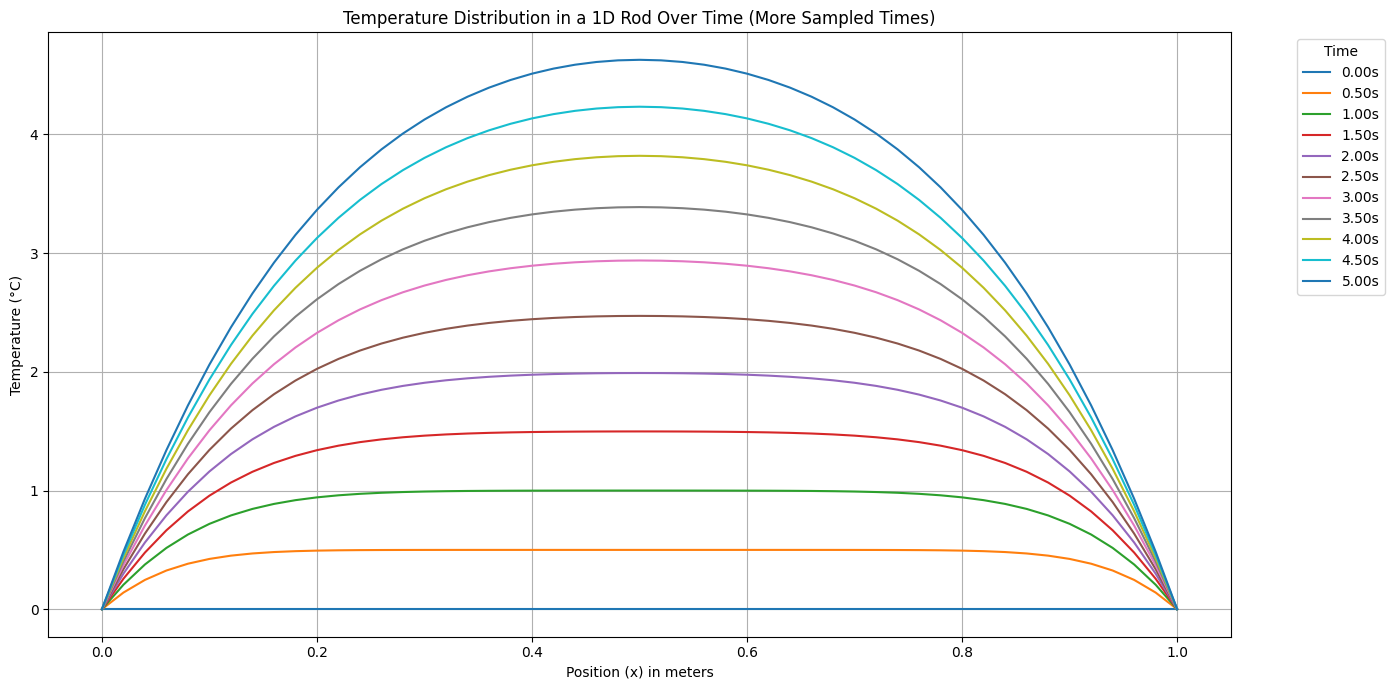

In [7]:
# --- Updated Line Plot with More Sampled Times ---

# Choose a regular time interval (e.g., every 0.5 seconds)
sample_interval = 0.5
available_times = df['Time (s)'].to_numpy()
selected_times = [t for t in np.arange(0.0, T_total + sample_interval, sample_interval)]

# Find closest available times in the dataset to ensure we have exact matches
closest_times = []
for t in selected_times:
    idx = (np.abs(available_times - t)).argmin()
    closest_times.append(available_times[idx])

# Remove duplicates (if any) and sort
closest_times = sorted(set(closest_times))
times_to_plot_df = df[df['Time (s)'].isin(closest_times)]

# Prepare x-axis values
x_cols = [col for col in df.columns if col.startswith('x=')]
x_values = np.array([float(col.split('=')[1][:-1]) for col in x_cols])

# --- Plotting ---
plt.figure(figsize=(14, 7))

for _, row in times_to_plot_df.iterrows():
    time_val = row['Time (s)']
    temp_values = row[x_cols].values.astype(float)
    plt.plot(x_values, temp_values, label=f'{time_val:.2f}s')

plt.title('Temperature Distribution in a 1D Rod Over Time (More Sampled Times)')
plt.xlabel('Position (x) in meters')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend(title='Time', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.tight_layout()
plt.savefig('temperature_distribution_more_times.png')
plt.show()


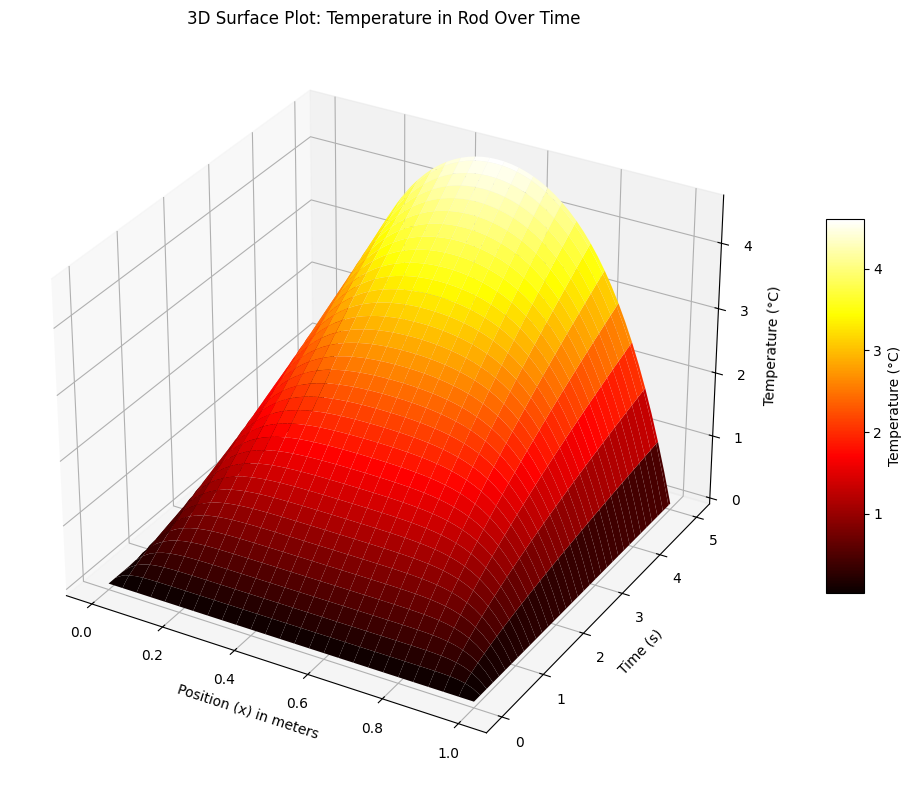

In [8]:
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(x_vals, time_vals)
Z = heatmap_data

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='hot')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Temperature (°C)')
ax.set_xlabel('Position (x) in meters')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Temperature (°C)')
ax.set_title('3D Surface Plot: Temperature in Rod Over Time')
plt.tight_layout()
plt.savefig('temperature_surface_plot.png')
plt.show()


In [ ]:
display(df.head(), df.tail())

,Time (s),x=0.00m,x=0.02m,x=0.04m,x=0.06m,x=0.08m,x=0.10m,x=0.12m,x=0.14m,x=0.16m,...,x=0.82m,x=0.84m,x=0.86m,x=0.88m,x=0.90m,x=0.92m,x=0.94m,x=0.96m,x=0.98m,x=1.00m
0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.05,0.0,0.033168,0.045299,0.048901,0.049782,0.049963,0.049995,0.049999,0.050000,...,0.050000,0.050000,0.049999,0.049995,0.049963,0.049782,0.048901,0.045299,0.033168,0.0
2,0.10,0.0,0.053256,0.080366,0.092604,0.097499,0.099239,0.099791,0.099948,0.099988,...,0.099998,0.099988,0.099948,0.099791,0.099239,0.097499,0.092604,0.080366,0.053256,0.0
3,0.15,0.0,0.068942,0.109313,0.131083,0.141866,0.146766,0.148810,0.149595,0.149872,...,0.149962,0.149872,0.149595,0.148810,0.146766,0.141866,0.131083,0.109313,0.068942,0.0
4,0.20,0.0,0.082256,0.134458,0.165590,0.182993,0.192094,0.196546,0.198581,0.199452,...,0.199801,0.199452,0.198581,0.196546,0.192094,0.182993,0.165590,0.134458,0.082256,0.0


,Time (s),x=0.00m,x=0.02m,x=0.04m,x=0.06m,x=0.08m,x=0.10m,x=0.12m,x=0.14m,x=0.16m,...,x=0.82m,x=0.84m,x=0.86m,x=0.88m,x=0.90m,x=0.92m,x=0.94m,x=0.96m,x=0.98m,x=1.00m
96,4.80,0.0,0.474276,0.910587,1.310961,1.677405,2.011899,2.316386,2.592762,2.842871,...,3.068495,2.842871,2.592762,2.316386,2.011899,1.677405,1.310961,0.910587,0.474276,0.0
97,4.85,0.0,0.476813,0.915651,1.318528,1.687439,2.024355,2.331207,2.609881,2.862212,...,3.089973,2.862212,2.609881,2.331207,2.024355,1.687439,1.318528,0.915651,0.476813,0.0
98,4.90,0.0,0.479336,0.920686,1.326051,1.697416,2.036741,2.345945,2.626906,2.881447,...,3.111333,2.881447,2.626906,2.345945,2.036741,1.697416,1.326051,0.920686,0.479336,0.0
99,4.95,0.0,0.481845,0.925691,1.333531,1.707337,2.049056,2.360600,2.643835,2.900576,...,3.132577,2.900576,2.643835,2.360600,2.049056,1.707337,1.333531,0.925691,0.481845,0.0
100,5.00,0.0,0.484340,0.930669,1.340969,1.717201,2.061303,2.375174,2.660672,2.919601,...,3.153707,2.919601,2.660672,2.375174,2.061303,1.717201,1.340969,0.930669,0.484340,0.0


In [ ]:
# --- Prepare (x, t, u) triplet data ---
data_triplets = []
for _, row in df.iterrows():
    t = row["Time (s)"]
    for col in df.columns[1:]:
        x = float(col.split('=')[1][:-1])
        u_val = row[col]
        data_triplets.append([x, t, u_val])
data_array = np.array(data_triplets)

X_data = data_array[:, 0:2]  # x, t
y_data = data_array[:, 2:3]  # u

display(X_data[:3], y_data[:3])

array([[0.  , 0.  ],
       [0.02, 0.  ],
       [0.04, 0.  ]])

array([[0.],
       [0.],
       [0.]])

In [ ]:
# --- Prepare (x, t, u) triplet data ---
data_triplets = []
for _, row in df.iterrows():
    t = row["Time (s)"]
    for col in df.columns[1:]:
        x = float(col.split('=')[1][:-1])
        u_val = row[col]
        data_triplets.append([x, t, u_val])
data_array = np.array(data_triplets)

X_data = data_array[:, 0:2]  # x, t
y_data = data_array[:, 2:3]  # u

# --- Geometry and domain ---
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 5.0)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# --- Trainable variables ---
raw_kappa = tf.Variable(0.0)
raw_q = tf.Variable(0.0)

def pde(x, u):
    du_t = dde.grad.jacobian(u, x, j=1)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    kappa = tf.nn.softplus(raw_kappa)
    q = raw_q
    return du_t - kappa * du_xx - q

# --- Optional: Add regularization around true values to stabilize training ---
def custom_loss(y_true, y_pred):
    base_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    reg = 10.0 * (tf.square(tf.nn.softplus(raw_kappa) - 0.01) + tf.square(raw_q - 1.0))
    return base_loss + reg

# --- Train/test split ---
from sklearn.model_selection import train_test_split
x_train, x_test, u_train, u_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# --- DeepXDE Data object ---
data = dde.data.TimePDE(
    geomtime,
    pde,
    [dde.PointSetBC(x_train, u_train)],  # Observed values as pseudo-BC
    num_domain=10000,
    num_boundary=0,
    num_initial=0,
    anchors=x_test,
)

# --- Neural Network ---
net = dde.maps.FNN([2] + [64]*3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# --- Train with Adam ---
model.compile("adam", lr=1e-4, loss=custom_loss,
              external_trainable_variables=[raw_kappa, raw_q])
losshistory, train_state = model.train(iterations=100000)

# --- Optional L-BFGS-B fine-tuning ---
model.compile("L-BFGS-B", loss=custom_loss,
              external_trainable_variables=[raw_kappa, raw_q])
model.train()

# --- Results ---
learned_kappa = tf.nn.softplus(raw_kappa).numpy()
learned_q = raw_q.numpy()
print("\n--- Results ---")
print(f"True kappa: 0.01, Learned kappa: {learned_kappa:.6f}")
print(f"True q: 1.0, Learned q: {learned_q:.6f}")


Compiling model...
'compile' took 0.017239 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.47e+01, 1.77e+01]    [1.47e+01, 1.77e+01]    []  
1000      [1.22e+01, 1.29e+01]    [1.22e+01, 1.29e+01]    []  
2000      [1.01e+01, 1.07e+01]    [1.01e+01, 1.07e+01]    []  
3000      [8.21e+00, 8.89e+00]    [8.21e+00, 8.89e+00]    []  
4000      [6.61e+00, 7.28e+00]    [6.61e+00, 7.28e+00]    []  
5000      [5.25e+00, 5.90e+00]    [5.25e+00, 5.90e+00]    []  
6000      [4.09e+00, 4.74e+00]    [4.09e+00, 4.74e+00]    []  
7000      [3.14e+00, 3.77e+00]    [3.14e+00, 3.77e+00]    []  
8000      [2.38e+00, 2.99e+00]    [2.38e+00, 2.99e+00]    []  
9000      [1.79e+00, 2.39e+00]    [1.79e+00, 2.39e+00]    []  
10000     [1.35e+00, 1.93e+00]    [1.35e+00, 1.93e+00]    []  
11000     [1.05e+00, 1.61e+00]    [1.05e+00, 1.61e+00]    []  
12000     [8.50e-01, 1.39e+00]    [8.50e-01, 1.39e+00]    []  
13000     [7.16e-01, 1.24e+00]    [7.16e-01, 1

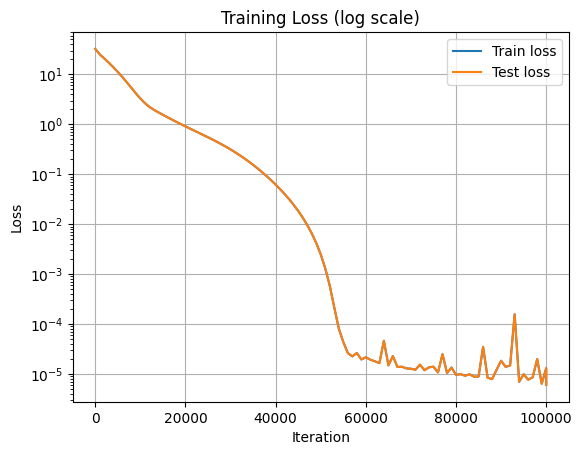

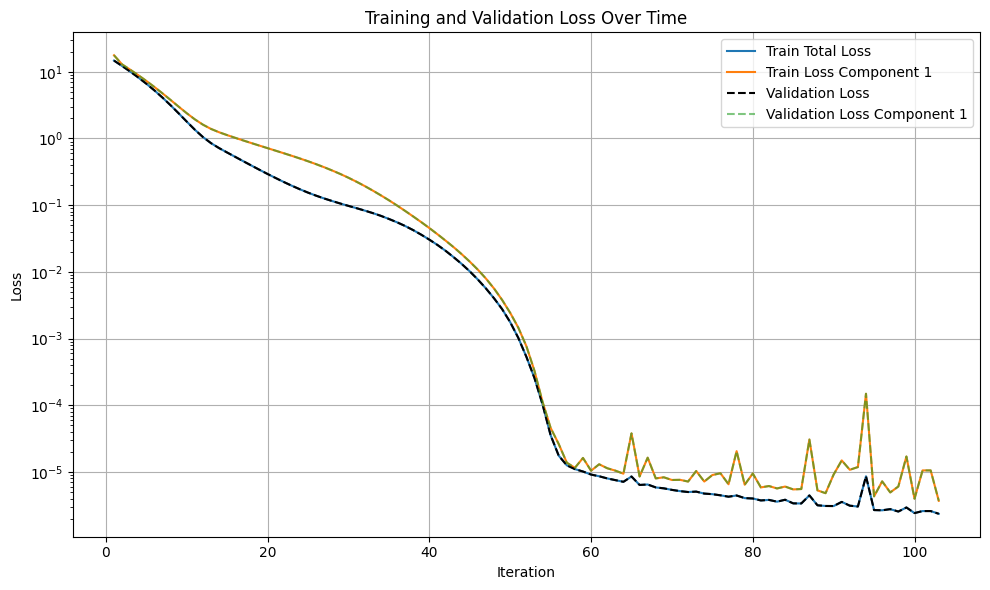

In [ ]:
# --- Plot loss ---
dde.utils.plot_loss_history(losshistory)
plt.yscale("log")
plt.title("Training Loss (log scale)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# --- Detailed loss plotting ---
losses = np.array(losshistory.loss_train)  # shape: (iterations, num_components)
iterations = np.arange(1, len(losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations, losses[:, 0], label="Train Total Loss")

# If there are multiple components (e.g., PDE + BC + data), plot them
if losses.shape[1] > 1:
    for i in range(1, losses.shape[1]):
        plt.plot(iterations, losses[:, i], label=f"Train Loss Component {i}")

# Plot validation loss if available
if losshistory.loss_test:
    val_losses = np.array(losshistory.loss_test)
    plt.plot(iterations, val_losses[:, 0], '--', label="Validation Loss", color="black")

    # Optionally: plot validation loss components
    if val_losses.shape[1] > 1:
        for i in range(1, val_losses.shape[1]):
            plt.plot(iterations, val_losses[:, i], '--', label=f"Validation Loss Component {i}", alpha=0.6)

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


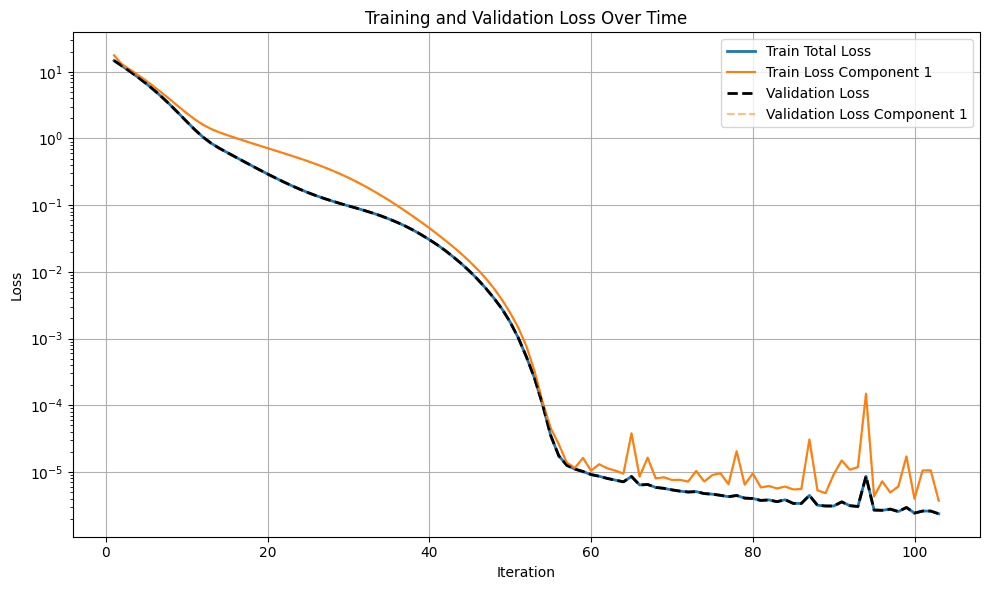

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# --- Prepare losses ---
losses = np.array(losshistory.loss_train)
iterations = np.arange(1, len(losses) + 1)
num_components = losses.shape[1]
colors = plt.get_cmap("tab10").colors  # 10 visually distinct colours

plt.figure(figsize=(10, 6))

# Plot total loss
plt.plot(iterations, losses[:, 0], label="Train Total Loss", color=colors[0], linewidth=2)

# Plot each loss component
for i in range(1, num_components):
    plt.plot(iterations, losses[:, i], label=f"Train Loss Component {i}", color=colors[i % len(colors)], linestyle='-')

# Plot validation loss if available
if losshistory.loss_test:
    val_losses = np.array(losshistory.loss_test)
    plt.plot(iterations, val_losses[:, 0], '--', label="Validation Loss", color="black", linewidth=2)

    for i in range(1, val_losses.shape[1]):
        plt.plot(iterations, val_losses[:, i], '--', label=f"Validation Loss Component {i}",
                 color=colors[i % len(colors)], alpha=0.5)

# --- Final touches ---
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
